Importing necessary packages

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import backtrader as bt
import numpy as np
from cvxopt import matrix, solvers,blas
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import cvxopt as opt

Notebook Settings

In [10]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)
%matplotlib inline
np.random.seed(42)
solvers.options['show_progress'] = False

Load the data

In [11]:
df = pd.read_csv('prices.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Get the minimum and maximum dates
start_date = df['date'].min()
end_date = df['date'].max()

# Create a DataFrame with all combinations of tickers and dates
tickers = df['ticker'].unique()
dates = pd.date_range(start=start_date, end=end_date, freq='D')
index = pd.MultiIndex.from_product([tickers, dates], names=['ticker', 'date'])
dummy_df = pd.DataFrame(index=index).reset_index()

# Merge the dummy DataFrame with the original DataFrame
merged_df = pd.merge(dummy_df, df, on=['ticker', 'date'], how='left')

# Forward fill missing values with next available value
merged_df['close'] = merged_df.groupby('ticker')['close'].fillna(method='bfill')

# Backward fill remaining missing values with previous available value
merged_df['close'] = merged_df.groupby('ticker')['close'].fillna(method='ffill')

df=merged_df
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
print(tabulate(df.head(), headers='keys', tablefmt='psql'))
print(f'Records from {df.index.min()} to {df.index.max()}')
print(f'Tickers: {df.ticker.unique()}')

+---------------------+----------+--------+--------+--------+---------+
| date                | ticker   |   open |   high |    low |   close |
|---------------------+----------+--------+--------+--------+---------|
| 2010-01-04 00:00:00 | AXISBANK | 198.78 | 199.99 | 197.62 | 140.712 |
| 2010-01-05 00:00:00 | AXISBANK | 199.6  | 204    | 199.14 | 143.648 |
| 2010-01-06 00:00:00 | AXISBANK | 204    | 205.74 | 198.51 | 141.237 |
| 2010-01-07 00:00:00 | AXISBANK | 199.29 | 201.2  | 197.82 | 142.237 |
| 2010-01-08 00:00:00 | AXISBANK | 200.6  | 203.98 | 199.27 | 144.095 |
+---------------------+----------+--------+--------+--------+---------+
Records from 2010-01-04 00:00:00 to 2020-06-15 00:00:00
Tickers: ['AXISBANK' 'BAJAJFINSV' 'BAJAJHLDNG' 'BAJFINANCE' 'BANDHANBNK'
 'BANKBARODA' 'GICRE' 'HDFC' 'HDFCAMC' 'HDFCBANK' 'HDFCLIFE' 'IBULHSGFIN'
 'ICICIBANK' 'ICICIGI' 'ICICIPRULI' 'INDUSINDBK' 'KOTAKBANK' 'L&TFH'
 'NIACL' 'PEL' 'PFC' 'PNB' 'SBILIFE' 'SBIN' 'SRTRANSFIN']


Plot of Covariance matrix

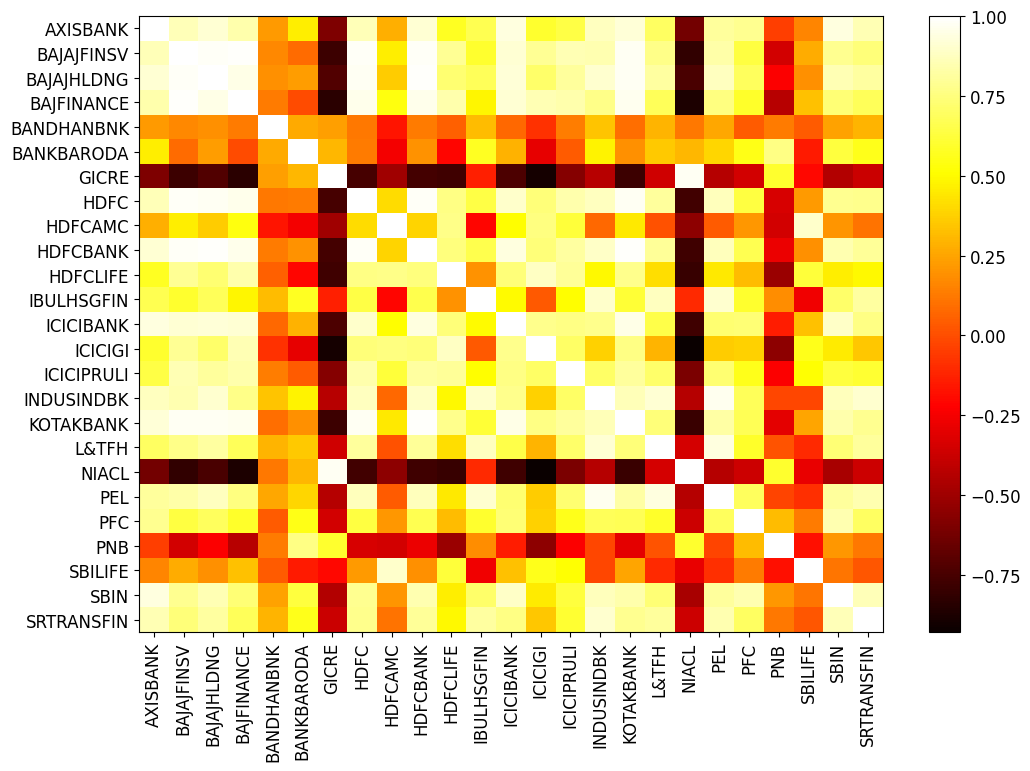

In [45]:
# Create a dictionary of DataFrames, one for each ticker
dfs = {ticker: df[df['ticker'] == ticker].copy() for ticker in df['ticker'].unique()}
# plot the correlation matrix of closing prices of all tickers with each other, darker colors indicate higher correlation
close_df = df.pivot_table(index='date', columns='ticker', values='close')
corr_df = close_df.corr(method='pearson')
plt.figure(figsize=(12, 8))
plt.imshow(corr_df.values, cmap='hot', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation='vertical')
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.show()

Plot of closing prices of all tickers

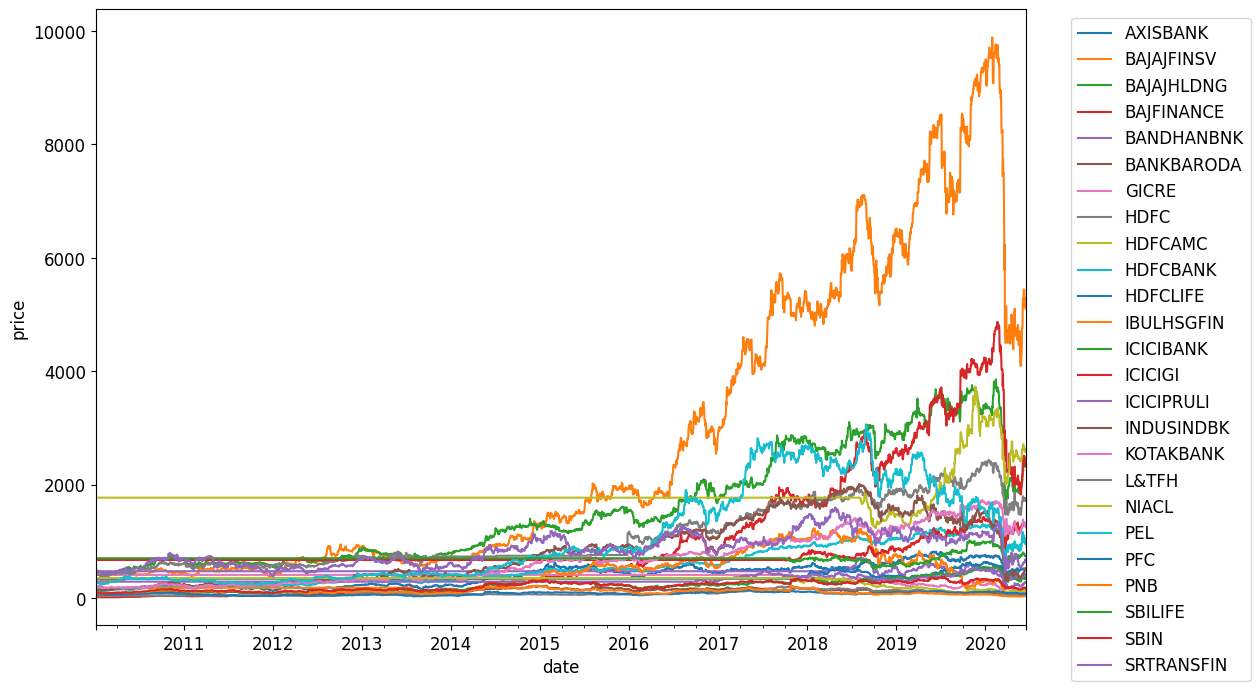

In [46]:
# visualize the closing prices of all tickers
close_df.plot(figsize=(12, 8))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('price')
plt.show()

# For a single company

Momentum Strategy

In [12]:
class MomentumSingle(bt.Strategy):
    ''' Momentum strategy with single stock '''
    def __init__(self):
        self.dataclose = self.datas[0].close
    
    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} | {txt}')
    
    def next(self):
        if self.dataclose[-2] > self.dataclose[-1]:
            self.order = self.buy()
            self.log(f'Buy order executed at {self.dataclose[0]}')
        elif self.dataclose[-2] < self.dataclose[-1]:
            self.order = self.sell()
            self.log(f'Sell order executed at {self.dataclose[0]}')
        else:
            self.order = self.close()
            self.log(f'Close order executed at {self.dataclose[0]}')
        
            

Test the strategy

In [13]:
single_cb = bt.Cerebro()
single_cb.addstrategy(MomentumSingle)
single_cb.broker.setcash(100000.0)
print(f'Starting Portfolio Value: {single_cb.broker.getvalue():.2f}')
for ticker in df['ticker'].unique():
    df1 = df[df['ticker'] == ticker]
    
    df_feed = bt.feeds.PandasData(dataname=df1,
                                  open='close',
                                  close='close',
                                  high='close',
                                  low='close',
                                  volume=None,
                                  openinterest=None,
                                  datetime=None,
                                  fromdate=datetime.datetime(2010, 1, 1),
                                  todate=datetime.datetime(2020, 12, 31))
    single_cb.adddata(df_feed)
    break

single_cb.run()
print(f'Final Portfolio Value: {single_cb.broker.getvalue():.2f}')


Starting Portfolio Value: 100000.00
2010-01-04 | Close order executed at 140.71202087402344
2010-01-05 | Buy order executed at 143.64793395996094
2010-01-06 | Sell order executed at 141.23680114746094
2010-01-07 | Buy order executed at 142.23672485351562
2010-01-08 | Sell order executed at 144.0947265625
2010-01-09 | Sell order executed at 148.8390350341797
2010-01-10 | Sell order executed at 148.8390350341797
2010-01-11 | Close order executed at 148.8390350341797
2010-01-12 | Close order executed at 148.82484436035156
2010-01-13 | Buy order executed at 147.54833984375
2010-01-14 | Buy order executed at 151.20761108398438
2010-01-15 | Sell order executed at 152.86703491210938
2010-01-16 | Sell order executed at 157.1007537841797
2010-01-17 | Sell order executed at 157.1007537841797
2010-01-18 | Close order executed at 157.1007537841797
2010-01-19 | Close order executed at 156.83126831054688
2010-01-20 | Buy order executed at 153.71095275878906
2010-01-21 | Buy order executed at 150.519

Plotting the result

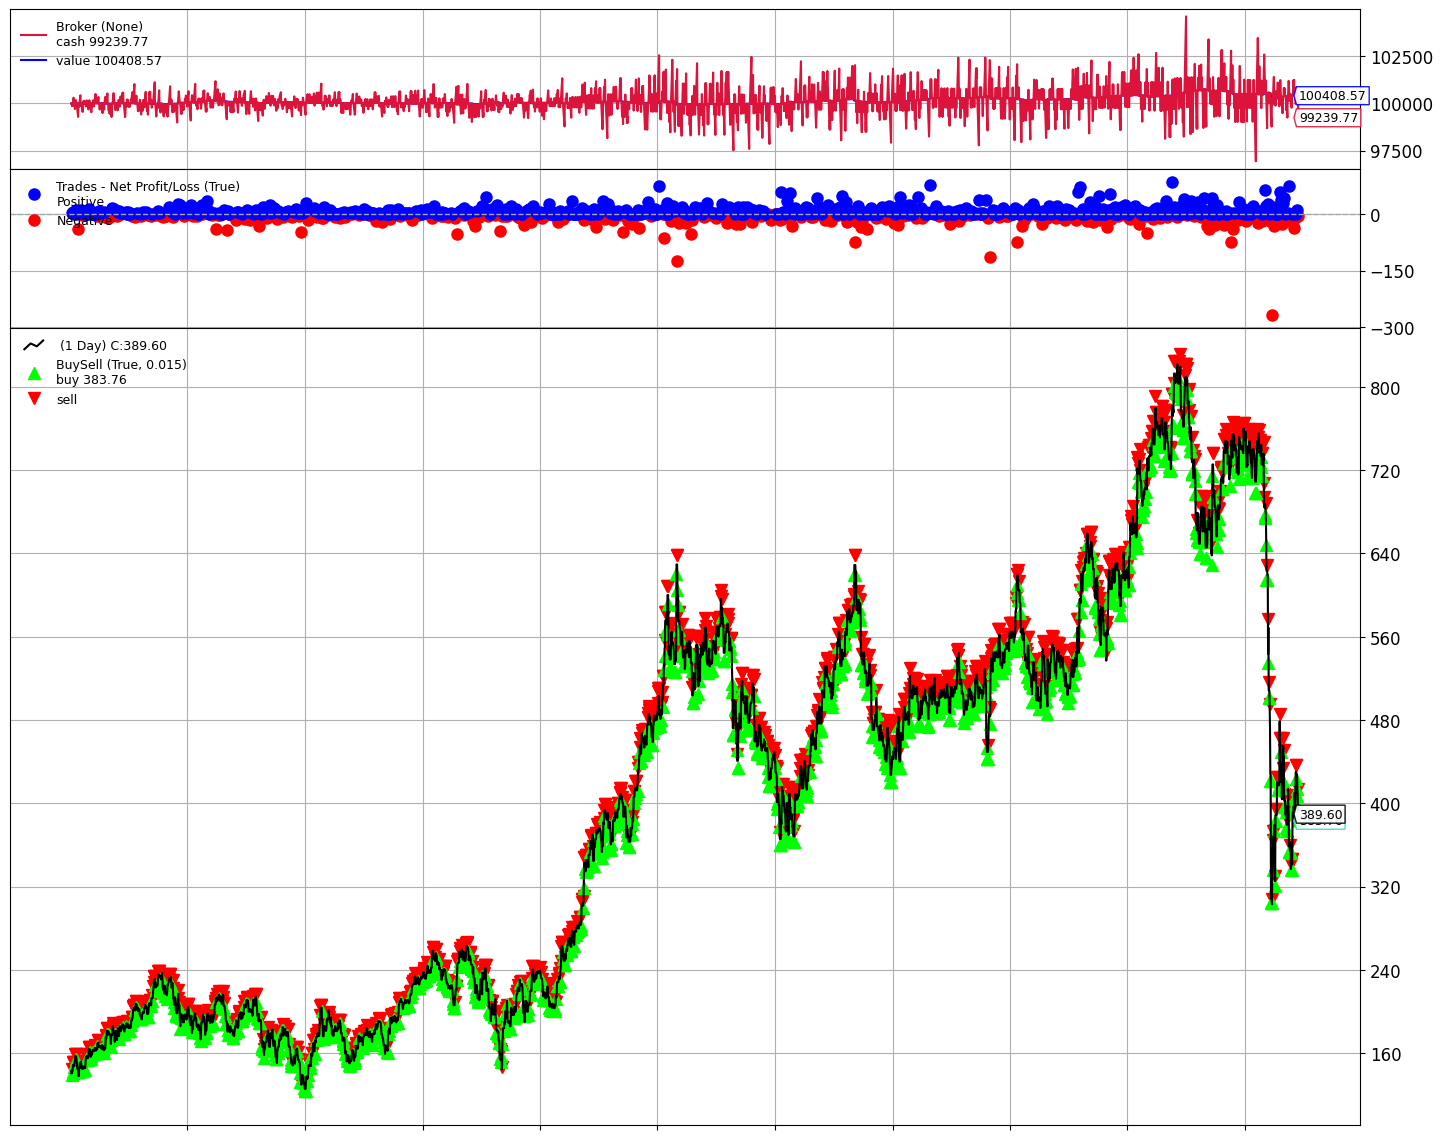

[[<Figure size 1500x1200 with 3 Axes>]]

In [14]:
plt.rcParams['figure.figsize'] = [15,12]
plt.rcParams.update({'font.size': 12})
single_cb.plot(iplot=False,volume=False)

Mean Variance Optimization Strategy

In [34]:
class MeanVarOpt(bt.Strategy):
    params = (
        ('sma',200),
        ('lookback',500),
        ('risk_tolerance',1),
        ('rebalance_day',1)
    )
    
    def __init__(self):
        self.SMA = []
        self.close_over_sma = []
        self.weights = np.ones(len(self.datas))/len(self.datas)
        for i, d in enumerate(self.datas):
            self.SMA.append(bt.indicators.SMA(d.close, period=self.params.sma))

    def log(self, txt):
        return
        dt = self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} | {txt}')

    def stop(self):
        for i, d in enumerate(self.datas):
            self.close(data=d)
    
    def calculate_portfolio_weights(self):
        if len(self.datas[0]) < self.params.lookback:
            return
        n_portfolios = len(self.datas)
        prices = np.zeros((n_portfolios, self.params.lookback))
        returns = np.zeros((n_portfolios, self.params.lookback))
        for i, d in enumerate(self.datas):
            prices[i,:] = d.close.get(size=self.params.lookback)
            returns[i,1:] = np.diff(prices[i,:])/prices[i,:-1]
        returns = np.asmatrix(returns)
        N = 100
        mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
        S = opt.matrix(np.cov(returns))
        pbar = opt.matrix(np.mean(returns, axis=1))
        # Create constraint matrices
        G = -opt.matrix(np.eye(n_portfolios))   # negative n x n identity matrix
        h = opt.matrix(0.0, (n_portfolios ,1))
        A = opt.matrix(1.0, (1, n_portfolios))
        b = opt.matrix(1.0)
        # Calculate efficient frontier weights using quadratic programming
        portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
        # Calculate risks and returns for frontier
        returns = [blas.dot(pbar, x) for x in portfolios]
        risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
        # Calculate the 2nd degree polynomial of the frontier curve
        m1 = np.polyfit(returns, risks, 2)
        x1 = np.sqrt(m1[2] / m1[0])
        # Calculate the optimal portfolio
        wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
        self.weights = np.asarray(wt)
        self.weights /= np.sum(self.weights)
        # incoporate risk tolerance
        self.weights *= self.params.risk_tolerance

    def next(self):
        curr_date = self.data.datetime.date(0)
        if curr_date.day != self.params.rebalance_day:
            return
        self.log(f'Processing {curr_date}')
        self.selected_stocks = []
        for i, d in enumerate(self.datas):
            if d.close[-1] > self.SMA[i][-1]:
                self.selected_stocks.append(d._name)
        self.log(f'Selected stocks: {self.selected_stocks}')
        self.calculate_portfolio_weights()
        for i, d in enumerate(self.datas):
            if d._name in self.selected_stocks:
                self.log(f'Ordering {d._name} with weight {self.weights[i]}')
                self.order_target_percent(data=d, target=self.weights[i])
            else:
                self.log(f'Closing {d._name}')
                self.close(data=d)


In [35]:
cb = bt.Cerebro()
cb.addstrategy(MeanVarOpt)
starting_portfolio_value = 1000000000.0
cb.broker.setcash(1000000000.0)
print(f'Starting Portfolio Value: {cb.broker.getvalue():.2f}')
for ticker in df['ticker'].unique():
    df1 = df[df['ticker'] == ticker]
    
    df_feed = bt.feeds.PandasData(dataname=df1,
                                  open='close',
                                  close='close',
                                  high='close',
                                  low='close',
                                  volume=None,
                                  openinterest=None,
                                  datetime=None,
                                  fromdate=datetime.datetime(2010, 1, 1),
                                  todate=datetime.datetime(2020, 12, 31))
    cb.adddata(df_feed, name=ticker)

cb.run()
ending_portfolio_value = cb.broker.getvalue()
print(f'Final Portfolio Value: {cb.broker.getvalue():.2f}')
print(f'Profit from strategy: {ending_portfolio_value - starting_portfolio_value:.2f}')
print(f'% Return: {(ending_portfolio_value - starting_portfolio_value)/starting_portfolio_value*100:.2f}%')


Starting Portfolio Value: 1000000000.00
Final Portfolio Value: 6436032367.13
Profit from strategy: 5436032367.13
% Return: 543.60%


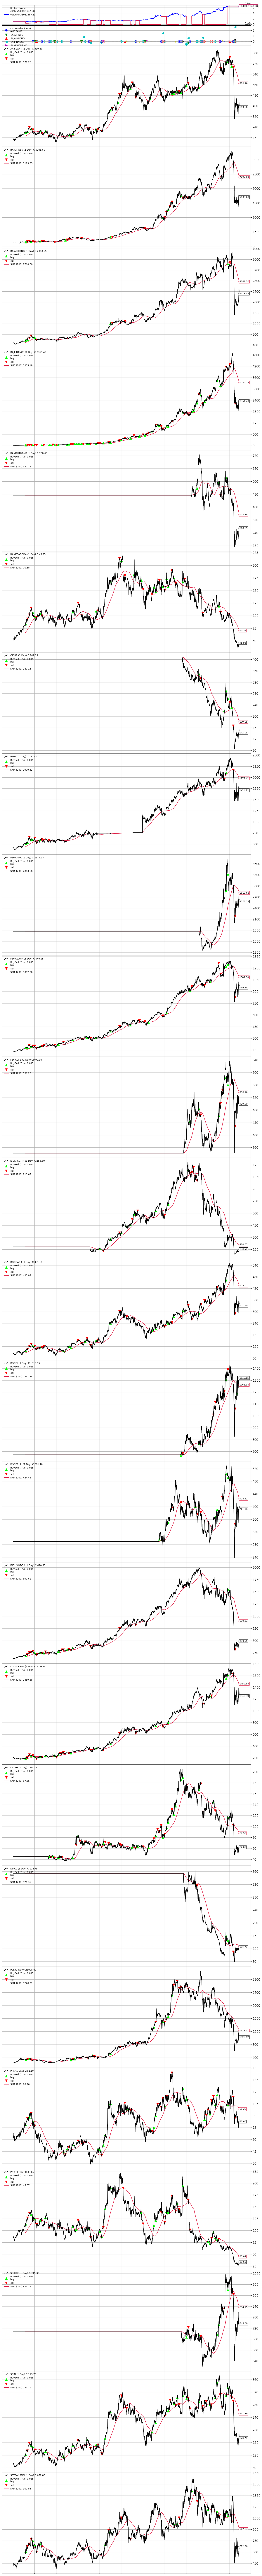

[[<Figure size 1500x15000 with 27 Axes>]]

In [36]:
plt.rcParams['figure.figsize'] = [15,150]
plt.rcParams.update({'font.size': 12})
cb.plot(iplot=False,volume=False)